Training an image classifier
We will do the following steps in order:

- Load and normalize the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

1) Load the dataset CIFAR10

In [12]:
import torch 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4
# Load the train and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes=('plane', 'car', 'bird', 'cat',
         'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's show some images

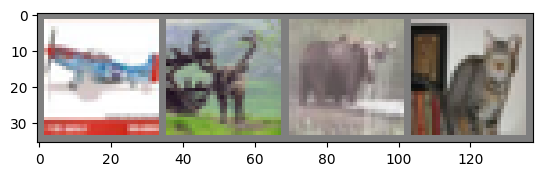

plane deer  deer  cat  


In [14]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2) Define a CNN

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

3) Define a Loss Function and Optimizer

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4) Train the network: train our data with loop (epochs)

In [17]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the inputs
        inputs, labels = data

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        #update of parameters
        optimizer.step()

        running_loss += loss.item() #print every 2000 batches
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

[1,  2000] loss: 2.179
[1,  4000] loss: 1.852
[1,  6000] loss: 1.676
[1,  8000] loss: 1.578
[1, 10000] loss: 1.526
[1, 12000] loss: 1.479
[2,  2000] loss: 1.403
[2,  4000] loss: 1.381
[2,  6000] loss: 1.329
[2,  8000] loss: 1.325
[2, 10000] loss: 1.305
[2, 12000] loss: 1.286


Let's save our trained model

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

5) Test the network on the test data
We will check by predicting the class label that the NN outputs, and checking it against the ground-truth. I fthe prediction is correct , we add the sample to teh list of correct predictions.

First step, let's display an image from the test set.

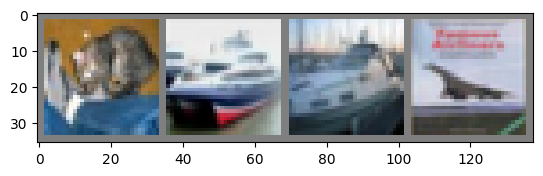

GroundTruth:  cat   ship  ship  plane


In [19]:
dataiter = iter(testloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

Now we should re-load the trained model from the PATH where we saved it

In [21]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

#outputs
outputs = net(images)

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class.
So, let's get the index of the highest energy

In [22]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  cat   ship  ship  ship 


The results are pretty good, just the last one is not correct. So, now, let's watch the results for teh entire test set.

In [23]:
correct = 0
total = 0
#since we are not training, we don't need to calculate the gradients for the outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


Now, let's identify the classes taht performed well and the ones that didn't.

In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.2 %
Accuracy for class: car   is 48.9 %
Accuracy for class: bird  is 38.7 %
Accuracy for class: cat   is 20.4 %
Accuracy for class: deer  is 54.7 %
Accuracy for class: dog   is 47.8 %
Accuracy for class: frog  is 64.5 %
Accuracy for class: horse is 71.9 %
Accuracy for class: ship  is 69.9 %
Accuracy for class: truck is 72.5 %
